In [118]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
# from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
# import pyro.optim as optim

from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [72]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [43]:
data = pd.read_csv('data/agg_data.csv')

In [44]:
data.columns

Index(['month', 'CensusTract', 'FELONY', 'MISDEMEANOR', 'VIOLATION',
       'TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap'],
      dtype='object')

In [45]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)

In [46]:
data['target'] = data['target'].astype(int)

In [47]:
features = ['month', 'CensusTract','TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap']

In [48]:
df_X = data[features]
df_y = data['target']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)

# Model

In [96]:
def model(data_x, data_y,total_pop,D):
    n_i = total_pop
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Binomial(n_i, p + u_i), obs=data_y)
    
    

In [97]:
X_np_train = np.array(X_train)
y_np_train = np.array(y_train)

X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

population =  torch.from_numpy(np.array(X_train['TotalPop'])).type(torch.float32)


In [98]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train, population,len(X_train.columns))

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


sample: 100%|██████████| 1200/1200 [00:59<00:00, 20.03it/s, step size=2.14e-03, acc. prob=0.799]


In [103]:

# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [104]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta0
           mean     std       5%       25%       50%       75%       95%
0  4.954189e-07  0.0001 -0.00018 -0.000059  0.000003  0.000069  0.000163 

Site: beta1
       mean       std        5%       25%       50%       75%       95%
0  0.000004  0.000092 -0.000155 -0.000057  0.000007  0.000071  0.000153 

Site: beta2
      mean       std        5%       25%       50%       75%       95%
0  0.00008  0.000063  0.000006  0.000034  0.000065  0.000111  0.000205 

Site: beta3
       mean       std        5%       25%       50%      75%       95%
0 -0.000013  0.000105 -0.000195 -0.000087 -0.000011  0.00007  0.000147 

Site: beta4
       mean       std        5%       25%       50%      75%       95%
0 -0.000005  0.000103 -0.000167 -0.000071 -0.000005  0.00006  0.000167 

Site: beta5
      mean       std        5%       25%       50%       75%       95%
0  0.00001  0.000109 -0.000156 -0.000067  0.000005  0.000083  0.000198 

Site: beta6
       mean       std        5%       25%     

In [114]:
sites = list(hmc_samples.keys())
sites

['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'sd_u', 'u_i']

beta0
beta1
beta2
beta3
beta4
beta5
beta6
sd_u


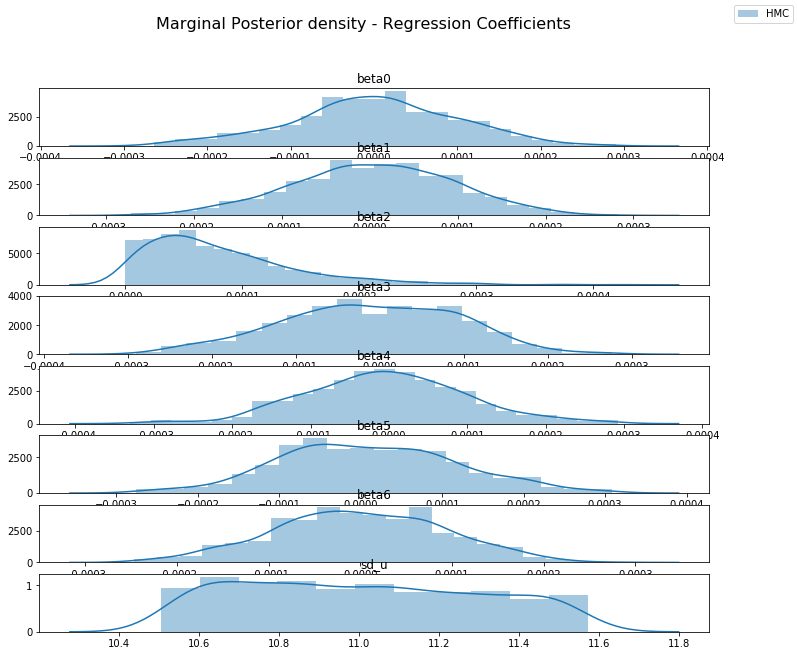

In [119]:
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
#     try:
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
#     except:
#         pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');